# The problem :

Given a data set with flight delay claims from 2013/01 to 2016/07. The goal is to predict claim amount for future flights.  Mathematically, minimize:

$\sum(Actual\ claim\ amount - Predicted\ claim\ amount)^2$

It is also assumed that every claim is $800. ie. For every flight, the insurance company pay either 0(no claim) or 800(claimed).

In [1]:
%matplotlib inline

import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import RandomForestRegressor
from math import cos, sin, tan, atan
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

num_cpus = 31

PAYABLE_ON_CLAIM = 800

pd.options.display.max_rows = 10

### Prepare raw data

In [2]:
data_path = 'data/flight_delays_data.csv'

if not os.path.exists(data_path):

    url = "https://www.dropbox.com/s/6marc0211lp4kg5/flight_delays_data.zip?dl=1"

    response = requests.get(url, stream=True)

    # Throw an error for bad status codes
    response.raise_for_status()

    with open('data/flight_delays_data.zip', 'wb') as handle:
        for block in response.iter_content(1024):
            handle.write(block)

    os.system("unzip data/flight_delays_data.zip -d data")
    os.system("rm -rf data/__MACOSX/")

raw_data_df = pd.read_csv(data_path)

In [3]:
# Supplymentary information: airport location

data_path = 'data/airport_info.csv'

if not os.path.exists(data_path):

    url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

    response = requests.get(url, stream=True)

    # Throw an error for bad status codes
    response.raise_for_status()

    with open(data_path, 'wb') as handle:
        for block in response.iter_content(1024):
            handle.write(block)

airport_info_df = pd.read_csv(data_path, 
                              names=["idx", "name", "location", "country", "code", "code2", "lat", "lng", "8", "9", "10", "11", "12", "13"],
                              index_col=0
                             )

In [4]:
def latlng_to_3d_pointer(lat, lon, alt=0, rad=1):
    # see: http://www.mathworks.de/help/toolbox/aeroblks/llatoecefposition.html
    f  = 0                              # flattening
    ls = atan((1 - f)**2 * tan(lat))    # lambda

    x = rad * cos(ls) * cos(lon) + alt * cos(lat) * cos(lon)
    y = rad * cos(ls) * sin(lon) + alt * cos(lat) * sin(lon)
    z = rad * sin(ls) + alt * sin(lat)

    return (x, y, z)

In [5]:
airport_3d_pointer_dict = dict()
for idx, row in airport_info_df.iterrows():
    code = row.code
    lat = row.lat
    lng = row.lng
    airport_3d_pointer_dict[code] = latlng_to_3d_pointer(lat, lng)
# Add missing
airport_3d_pointer_dict['DOH'] = latlng_to_3d_pointer(25.261100769, 51.5651016235)
airport_3d_pointer_dict['HYD'] = latlng_to_3d_pointer(17.24, 78.43)

### Understanding the dataset

In [6]:
raw_data_df.head(3)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0


In [7]:
# From where these flights depart?
raw_data_df.Departure.value_counts()

HKG    899114
Name: Departure, dtype: int64

In [8]:
# Where are these flights going?
raw_data_df.Arrival.value_counts()

TPE    75751
PVG    61598
BKK    49730
PEK    45161
SIN    44720
       ...  
SPN       10
XNN        6
JHG        3
DTW        3
LGA        1
Name: Arrival, Length: 163, dtype: int64

In [9]:
# How many flight is claimed?
raw_data_df.is_claim.value_counts()

0      859701
800     39413
Name: is_claim, dtype: int64

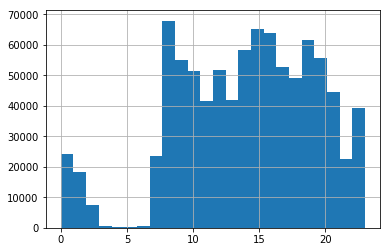

In [10]:
# When do flights take off?
raw_data_df.std_hour.hist(bins=24)

In [11]:
### Detect rows that with incomplete data
raw_data_df.isnull().sum()

flight_id         0
flight_no         0
Week              0
Departure         0
Arrival           0
Airline        1714
std_hour          0
delay_time        0
flight_date       0
is_claim          0
dtype: int64

In [12]:
### Fix the incomplete data

cleaned_data_df = raw_data_df.fillna("unknown")

### Let's try some machine learning ;)  -- First let's prepare the feature Vectors

In [13]:
# Encode Airline
airline_label_encoder = LabelEncoder()
integer_encoded_airline = airline_label_encoder.fit_transform(cleaned_data_df.Airline)
onehot_encoded_airline = to_categorical(integer_encoded_airline)
onehot_encoded_airline.shape

(899114, 123)

In [14]:
# Encode std_hr
onehot_std_hr = to_categorical(cleaned_data_df.std_hour, num_classes=24)
onehot_std_hr.shape

(899114, 24)

In [15]:
# Encode destination airport
airport_in_3d_space_encoded = np.stack(cleaned_data_df.Arrival.apply(lambda value: airport_3d_pointer_dict[value]).values, axis=0)
airport_in_3d_space_encoded.shape

(899114, 3)

In [16]:
# Encode week
week_encoded = to_categorical(cleaned_data_df.Week, num_classes=53)
week_encoded.shape

(899114, 53)

In [17]:
# HStack the encoded vectors
X = np.hstack([
    onehot_encoded_airline, 
    onehot_std_hr,
    airport_in_3d_space_encoded,
    week_encoded
])
Y = [0 if is_claim == 0 else 1 for is_claim in cleaned_data_df.is_claim]

# Create training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

### Establish the baseline
##### Find the optimal claim amount while no model is involved


Remember our optimization target:

$
    \sum(Actual\ claim\ amount - Predicted\ claim\ amount)^2
$


Assume all flight have the same probability of delay, then the optimal price is to find x such that y minimize in this equation:

$y = (1-p)x^2 + p(800 - x)^2 $
where$\ p\$ is the probability of delay.

Using property of quadratic equation: $y$ is minimized at $-b/2a$ where $a = 1, b=-800*2*p$

In [18]:
def claim_amount_based_on_probability_of_delay(p):
    # Setting the price by finding the minimum of y = (1-p)x^2 + p*((800 - x)^2) where p is the probability of delay.
    b = (-PAYABLE_ON_CLAIM*2*p)      # The b in quadratic equation
    a = 1                            # the a in quadratic equation
    minimun_x = -b/2*a               # -b/2a is the x position of local minimum
    return minimun_x

In [19]:
def calculate_optimization_target(claim_amount, label_set):  # claim amount can be a scala or a list
    
    # RMS is used instead of MS, just to make the number smaller,
    # easier to compare.
    
    RMS = int(math.sqrt(np.square(array(label_set) * PAYABLE_ON_CLAIM - claim_amount).sum()))
    return RMS

In [20]:
# While not segmenting the flights into groups, p = 39,413/899,114 (# delayed / # total flights)

p = 39413/899114
baseline_claim_amount = claim_amount_based_on_probability_of_delay(p)
baseline_opt_value = calculate_optimization_target(baseline_claim_amount, Y_test)

print("baseline_value (Every flight expect to claim {:.2f}): {:,}".format(baseline_claim_amount, baseline_opt_value))

baseline_value (Every flight expect to claim 35.07): 76,985


### Problem of our dataset

1. The dataset we have is very biasd - normal:delayed = 22:1

#### Why is it a problem? 
Let's think of a scenario:  
We stupidly predict all flights NOT delayed.  
Accuracy is already very high.  
(As high as 1 - 39,433/899,114 = 95.6%)  
Models can hardly converge.

### Let's try to solve the imbalance problem

In [21]:
# Over sample our training set.
sm = SMOTE(random_state=42)
X_train_SMOTE, Y_train_SMOTE = sm.fit_sample(X_train, Y_train)

In [22]:
X_train_SMOTE_small, _, Y_train_SMOTE_small, _ = train_test_split(X_train_SMOTE, Y_train_SMOTE, shuffle=True, test_size=0.5)

### Use Random Forest as model to give a score to indicate the likelyhood of flight delay

In [23]:
# Instantiate model with 500 decision trees
rf_smote = RandomForestRegressor(n_estimators = 500, random_state = 42, n_jobs=num_cpus)
# Train the model on training data
rf_smote.fit(X_train_SMOTE_small, Y_train_SMOTE_small)

array([[199867,  15235],
       [  5256,   4421]])

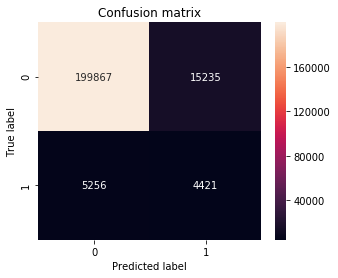

In [24]:
# Simple Evaluation using confusion matrix.

_pred = rf_smote.predict(X_test)
Y_pred = (_pred > 0.5)
plt.figure(figsize = (5,4))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot = True, fmt='g')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
cm

### Segment flights into groups according to the score given to each flight by our model.
#### Get the sampled probability of delay for every segments.

In [25]:
# We select the dataset and model to run

model = rf_smote
_X = X_train
_Y = Y_train

In [26]:
_pred = model.predict(X_train)

In [27]:
# Prob means the Sample Probability. ie. The probability is calculated from actual samples.

# score -> prob
score_to_prob_list = []
score_to_count_list = []
step = 0.1

# Cut it into ten group according to the score, and obtained the sample probability of delay.
# ie. Group 1 : scores in (0.0 - 0.1]  | Delay Probability = __
#     Group 2 : scores in (0.1 - 0.2]  | Delay Probability = __
#     Group 3 : scores in (0.2 - 0.3]  | Delay Probability = __

for cut in np.arange(0.0, 1, step):
    sample_in_p_range = ((_pred > cut) & (_pred <= cut + step)).reshape(-1)
    number_of_sample_in_range = sample_in_p_range.sum()
    number_of_positive_in_range = (np.array(_Y) * sample_in_p_range ).sum()
    probability_of_positive_in_range = number_of_positive_in_range/number_of_sample_in_range
    score_to_prob_list.append((cut, probability_of_positive_in_range))
    score_to_count_list.append((cut, number_of_sample_in_range))

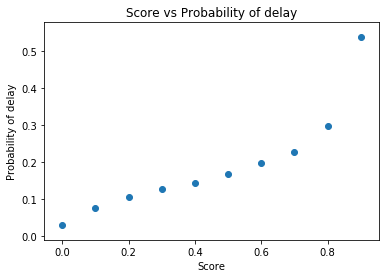

In [28]:
plt.scatter(*zip(*score_to_prob_list))
plt.title("Score vs Probability of delay")
plt.xlabel("Score")
plt.ylabel("Probability of delay")
plt.show()

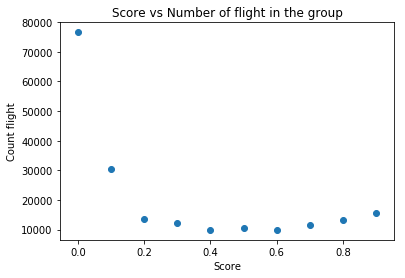

In [29]:
plt.scatter(*zip(*score_to_count_list))
plt.title("Score vs Number of flight in the group")
plt.xlabel("Score")
plt.ylabel("Count flight")
plt.show()

### Try to apply the new price and compare with the baseline value

In [30]:
def score_to_prob(score):
    for score_cut, prob in score_to_prob_list:
        if score <= score_cut + step:
            return prob
    return 1

In [31]:
per_flight_probability_of_delay = array(list(map(score_to_prob, _pred))).reshape(-1)

In [32]:
price_list = array(list(map(claim_amount_based_on_probability_of_delay, per_flight_probability_of_delay)))

In [33]:
# Calculate the optimization target, compare with baseline
modelled = calculate_optimization_target(price_list, Y_train)
baseline = calculate_optimization_target(baseline_claim_amount, Y_train)
print("Optimization target: {:,}(Modelled); {:,}(Baseline)".format(modelled, baseline))

Optimization target: 119,337(Modelled); 134,877(Baseline)


### Publishing the model

In [34]:
class FlightClaimAmountPredictor:
    def __init__(self, airline_label_encoder, airline_count, airport_3d_pointer_dict, model, score_to_prob_list):
        self.airline_label_encoder = airline_label_encoder
        self.airline_count = airline_count
        self.airport_3d_pointer_dict = airport_3d_pointer_dict
        self.model = model
        self.score_to_prob_list = score_to_prob_list
        
    def pred_to_prob(self, score):
        score_to_prob_list = self.score_to_prob_list
        for score_cut, prob in score_to_prob_list:
            if score <= score_cut + step:
                return prob
        return 1
    
    def claim_amount_based_on_probability_of_delay(self, p, uniform_claim_amount=800):
        # Setting the price by finding the minimum of y = x^2 + p*((800 - x)^2) where p is the probability of delay.
        b = (-2*uniform_claim_amount*p)      # The b in quadratic equation
        a = 1                                # the a in quadratic equation
        minimun_x = -b/2*a                   # -b/2a is the x position of local minimum
        return minimun_x
        
    def predict(self, input_df):
        airline_label_encoder = self.airline_label_encoder
        airport_3d_pointer_dict = self.airport_3d_pointer_dict
        model = self.model
        
        input_df = input_df.fillna("unknown")        
        
        # Encode airline
        integer_encoded_airline = airline_label_encoder.transform(input_df.Airline)
        onehot_encoded_airline = to_categorical(integer_encoded_airline, num_classes=self.airline_count)

        # Encode std_hr
        onehot_std_hr = to_categorical(input_df.std_hour, num_classes=24)

        # Encode airport
        airport_in_3d_space_encoded = np.stack(input_df.Arrival.apply(lambda value: airport_3d_pointer_dict[value]).values, axis=0)

        # Encode week
        week_encoded = to_categorical(input_df.Week, num_classes=53)
        
        X = np.hstack([
            onehot_encoded_airline, 
            onehot_std_hr,
            airport_in_3d_space_encoded,
            week_encoded
        ])
        _pred = model.predict(X)
        
        output = []
        
        for model_score in _pred:
            prob = self.pred_to_prob(model_score)
            claim_amount = self.claim_amount_based_on_probability_of_delay(prob)
            output.append(claim_amount)
            
        return array(output)
        

In [35]:
predictor = FlightClaimAmountPredictor(
    airline_label_encoder=airline_label_encoder, 
    airline_count=onehot_encoded_airline.shape[1],
    airport_3d_pointer_dict=airport_3d_pointer_dict, 
    model=rf_smote, 
    score_to_prob_list=score_to_prob_list
)

### Let's try the prediction on the whole set of data 
### (To test the model with another set of data, just replace the input dataframe here)

In [36]:
sampledf = raw_data_df
prediction = predictor.predict(sampledf)
sampledf['predicted_claim_amount'] = prediction

In [37]:
sum_squared_error = int(np.square(sampledf.is_claim - sampledf.predicted_claim_amount).sum())

In [38]:
baseline_squared_error = int(np.square(sampledf.is_claim - baseline_claim_amount).sum())

In [39]:
print("Optimization target (Mean-squared): {:,}(Modelled); {:,}(Baseline)".format(sum_squared_error, baseline_squared_error))

Optimization target (Mean-squared): 19,667,517,877(Modelled); 24,118,602,455(Baseline)


### Enhancement Directions 

1. This model aimed at optimizing the mean squared error.  Next step: explore other optimization targets.
2. Only class (delayed or not) is used as labels for training.  Next step: use delayed time as labels, make prediction on delayed time before predicting the actualy claim amount.
3. Random Forest is used as the core part of prediction.  Next step: try different models.